In [2]:
import pandas as pd
#from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm

Matplotlib is building the font cache; this may take a moment.


In [ ]:
"""train_df = pd.read_excel("self_training_annotated.xlsx", sheet_name="Sheet1", usecols=[5, 8, 9, 14, 16])
training_sample = train_df.groupby('language', group_keys=False).sample(n=20)
training_sample.columns"""

Index(['language', 'original_string', 'original_docstring', 'short_docstring',
       'modified_short_docstring'],
      dtype='object')
Length =  200


In [17]:
training_sample = pd.read_csv("annotations_labeled.csv")
#training_sample = train_df.groupby('label', group_keys=False).sample(n=45)
training_sample.columns

Index(['original_string', 'original_docstring', 'modified_short_docstring',
       'label'],
      dtype='object')

In [17]:
"""llm_set:list[dict] = []

for instance in tqdm(training_sample.itertuples()):
    language = instance.language
    original_doc = instance.original_docstring
    original_code = instance.original_string
    positive = instance.modified_short_docstring
    negative = instance.short_docstring

 
    llm_set.append({
        "code": original_code,
        "original_doc": original_doc,
        "candidate_sentence": positive,
        "label": 1
    })

    llm_set.append({
        "code": original_code,
        "original_doc": original_doc,
        "candidate_sentence": negative,
        "label": 0
    })"""



0it [00:00, ?it/s]

In [18]:
training_sample = training_sample.dropna()
len(training_sample)

160

In [19]:
X = training_sample.drop('label', axis=1)
y = training_sample['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Define transformers
preprocessor = ColumnTransformer(transformers=[
    ('tfidf_1', TfidfVectorizer(), 'original_string'),
    ('tfidf_2', TfidfVectorizer(), 'original_docstring'),
    ('tfidf_3', TfidfVectorizer(), 'modified_short_docstring')
])

# Full pipeline with classifier
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier())
])

In [21]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.7500
Classification Report:
              precision    recall  f1-score   support

          No       0.75      1.00      0.86        36
         Yes       0.00      0.00      0.00        12

    accuracy                           0.75        48
   macro avg       0.38      0.50      0.43        48
weighted avg       0.56      0.75      0.64        48



/home/a/adeniji/CIS732/documentation-simplification/cis732/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/a/adeniji/CIS732/documentation-simplification/cis732/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/a/adeniji/CIS732/documentation-simplification/cis732/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

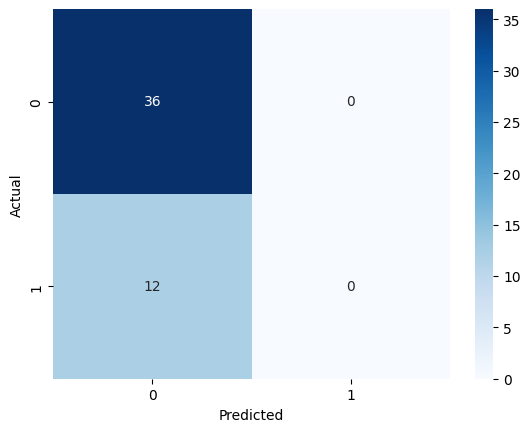

In [22]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()